In [2]:
import os
if not (os.path.isfile('data.zip') and os.path.isfile('data.zip')):
    !rm -rf model_discovery
    !rm -rf data
    import gdown
    # download source code
    gdown.download('https://drive.google.com/uc?id=1exw9vOYcb0fPVseleifK0m1VxbBCsBM_', output=None, quiet=False)
    # download data
    gdown.download('https://drive.google.com/uc?id=1ozrvNU128WOGWDVhhDKtZENzBMuO-w4i', output=None, quiet=False)

    !unzip -qq data.zip
    !unzip -qq model_discovery.zip

Downloading...
From: https://drive.google.com/uc?id=1exw9vOYcb0fPVseleifK0m1VxbBCsBM_
To: /content/model_discovery.zip
100%|██████████| 11.9k/11.9k [00:00<00:00, 3.88MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ozrvNU128WOGWDVhhDKtZENzBMuO-w4i
To: /content/data.zip
22.5MB [00:00, 49.4MB/s]


CREDIT: The code of ResNet was modified from: 
https://colab.research.google.com/github/raghumriyer/colab/blob/master/Resent_CIFAR10.ipynb

In [9]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
from model_discovery import utils
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split

import numpy as np
import os
import random
import itertools
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib import gridspec

def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


In [10]:
data_augmentation = True
num_classes = 10
# Subtracting pixel mean improves accuracy
subtract_pixel_mean = False

In [11]:
# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
# Input image dimensions.
input_shape = x_train.shape[1:]
# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [12]:
def train_res(x_train, y_train, x_test, y_test):
  # Training parameters
  batch_size = 32  # orig paper trained all networks with batch_size=128
  epochs = 20
  data_augmentation = True
  num_classes = 10
  # Subtracting pixel mean improves accuracy
  subtract_pixel_mean = False
  n = 9
  # Model version
  # Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
  version = 1
  # Computed depth from supplied model parameter n
  if version == 1:
      depth = n * 6 + 2
  elif version == 2:
      depth = n * 9 + 2
  # Model name, depth and version
  model_type = 'ResNet%dv%d' % (depth, version)
  if version == 2:
      model = resnet_v2(input_shape=input_shape, depth=depth)
  else:
      model = resnet_v1(input_shape=input_shape, depth=depth)

  model.compile(loss='categorical_crossentropy',
                optimizer=Adam(lr=lr_schedule(0)),
                metrics=['accuracy'])
  # model.summary()
  print(model_type)

  # Prepare model model saving directory.
  save_dir = os.path.join(os.getcwd(), 'saved_models')
  model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
  if not os.path.isdir(save_dir):
      os.makedirs(save_dir)
  filepath = os.path.join(save_dir, model_name)
  # Prepare callbacks for model saving and for learning rate adjustment.
  checkpoint = ModelCheckpoint(filepath=filepath,
                              monitor='val_acc',
                              verbose=1,
                              save_best_only=True)
  lr_scheduler = LearningRateScheduler(lr_schedule)
  lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                                cooldown=0,
                                patience=5,
                                min_lr=0.5e-6)
  callbacks = [checkpoint, lr_reducer, lr_scheduler]

  acc = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
  
  return model

## Construct balanced and imbalanced data

In [13]:
(x_train_raw, y_train_raw), (x_test_raw, y_test_raw) = cifar10.load_data()

x_train_groups = dict()
y_train_raw_groups = dict()
y_train_groups = dict()

random.seed(0)
for i in range(5):
    key = ''.join(['cifar10_group', str(i)])
    index = random.sample(range(0, x_train.shape[0]), 5000)
    x_train_groups[key] = x_train[index]
    y_train_groups[key] = y_train[index]
    y_train_raw_groups[key] = y_train_raw[index]
    index = np.where(y_train_raw == random.randint(0, 10))[0]
    x_train_groups[key] = np.concatenate((x_train_groups[key], x_train[index]))
    y_train_groups[key] = np.concatenate((y_train_groups[key], y_train[index]))
    y_train_raw_groups[key] = np.concatenate((y_train_raw_groups[key], y_train_raw[index]))

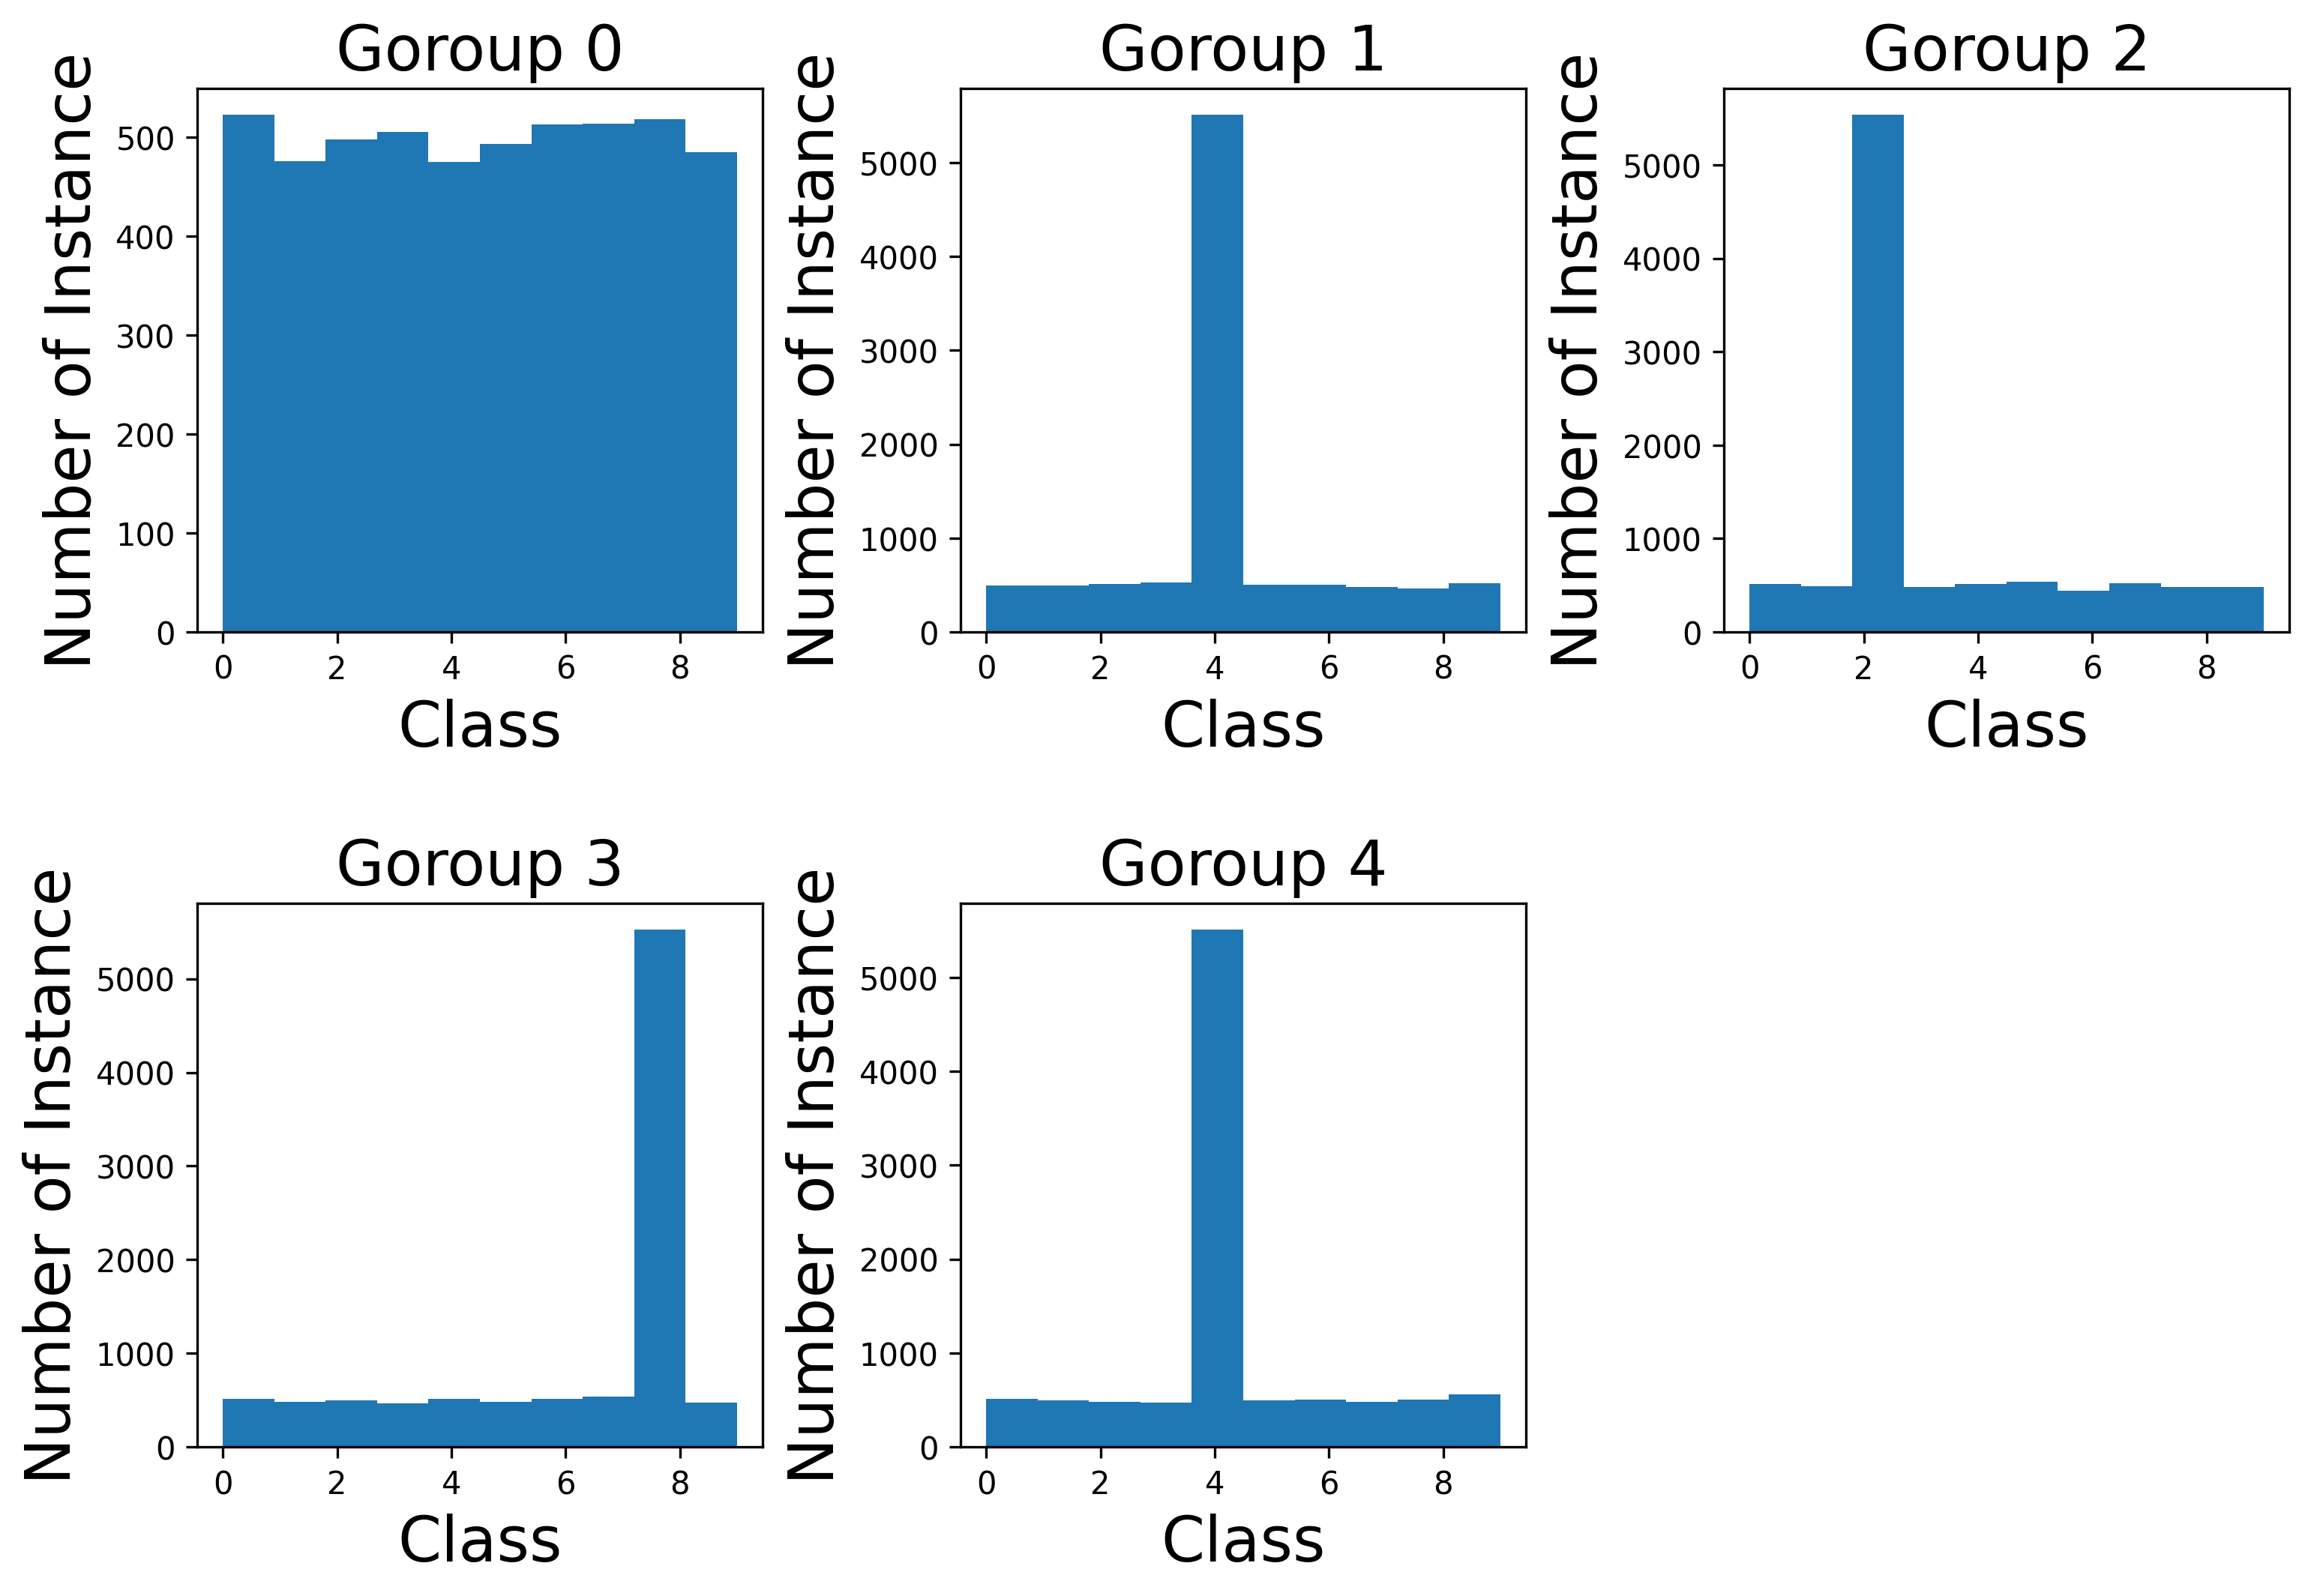

In [14]:
fig = plt.figure(figsize=(12,8), dpi=300)
gs = gridspec.GridSpec(2,3)

fontsize = 20

ax0 = plt.subplot(gs[0])
ax0.hist(y_train_raw_groups['cifar10_group0'])
ax0.set_xlabel('Class', fontsize=fontsize)
ax0.set_ylabel('Number of Instance', fontsize=fontsize)
ax0.set_title('Goroup 0', fontsize=fontsize)

ax1 = plt.subplot(gs[1])
ax1.hist(y_train_raw_groups['cifar10_group1'])
ax1.set_xlabel('Class', fontsize=fontsize)
ax1.set_ylabel('Number of Instance', fontsize=fontsize)
ax1.set_title('Goroup 1', fontsize=fontsize)

ax2 = plt.subplot(gs[2])
ax2.hist(y_train_raw_groups['cifar10_group2'])
ax2.set_xlabel('Class', fontsize=fontsize)
ax2.set_ylabel('Number of Instance', fontsize=fontsize)
ax2.set_title('Goroup 2', fontsize=fontsize)

ax3 = plt.subplot(gs[3])
ax3.hist(y_train_raw_groups['cifar10_group3'])
ax3.set_xlabel('Class', fontsize=fontsize)
ax3.set_ylabel('Number of Instance', fontsize=fontsize)
ax3.set_title('Goroup 3', fontsize=fontsize)

ax4 = plt.subplot(gs[4])
ax4.hist(y_train_raw_groups['cifar10_group4'])
ax4.set_xlabel('Class', fontsize=fontsize)
ax4.set_ylabel('Number of Instance', fontsize=fontsize)
ax4.set_title('Goroup 4', fontsize=fontsize)

plt.subplots_adjust(wspace=0.35, hspace=0.5)
plt.show()

In [15]:
comb = list(itertools.permutations(x_train_groups.keys(), 2))

cached_d1 = None
cached_model = None

d1_list = []
d2_list = []
serving_acc = []
source_acc = []
ada = []
jsd = []
l2d_list = []

for d1,d2 in tqdm(comb):
  d1_x = x_train_groups[d1]
  d1_y = y_train_groups[d1]
  d2_x = x_train_groups[d2]
  d2_y = y_train_groups[d2]

  d1_x_reshape = d1_x.reshape((d1_x.shape[0], -1))
  d2_x_reshape = d2_x.reshape((d2_x.shape[0], -1))
  center1 = utils.data_to_center(d1_x_reshape)
  center2 = utils.data_to_center(d2_x_reshape)

  temp_x_train, temp_x_test, temp_y_train, temp_y_test = train_test_split(d1_x, d1_y, test_size=0.1, random_state=0)

  prob1 = utils.data_to_probability(d1_x)
  prob2 = utils.data_to_probability(d2_x)
  if cached_d1 == None or cached_d1 != d1:
    cached_d1 = d1
    cached_model = train_res(temp_x_train, temp_y_train, temp_x_test, temp_y_test)
  elif cached_d1 == d1:
    pass

  acc = cached_model.evaluate(d2_x, d2_y)[1]
  src_acc = cached_model.evaluate(temp_x_test, temp_y_test)[1]
  d1_list.append(d1)
  d2_list.append(d2)
  serving_acc.append(acc)
  source_acc.append(src_acc)
  l2d_list.append(utils.l2_distance(center1, center2))
  jsd.append(utils.jensen_shannon_divergence(prob1, prob2))
  ada.append(utils.adaptivity(d1_x, d2_x, threshold=0.005, partition_size=500))



Learning rate:  0.001
ResNet56v1


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20
Learning rate:  0.001
141/141 [==============================] - 66s 62ms/step - loss: 3.2181 - accuracy: 0.2052 - val_loss: 3.8434 - val_accuracy: 0.1820
Epoch 2/20
Learning rate:  0.001
141/141 [==============================] - 4s 31ms/step - loss: 2.0893 - accuracy: 0.3935 - val_loss: 3.0521 - val_accuracy: 0.2560
Epoch 3/20
Learning rate:  0.001
141/141 [==============================] - 4s 31ms/step - loss: 1.8809 - accuracy: 0.4777 - val_loss: 3.4412 - val_accuracy: 0.2640
Epoch 4/20
Learning rate:  0.001
141/141 [==============================] - 4s 31ms/step - loss: 1.7323 - accuracy: 0.5280 - val_loss: 4.3340 - val_accuracy: 0.2720
Epoch 5/20
Learning rate:  0.001
141/141 [==============================] - 4s 31ms/step - loss: 1.5919 - accuracy: 0.5629 - val_loss: 2.1444 - val_accuracy: 0.4180
Epoch 6/20
Learning rate:  0.001
141/141 [==============================] - 4s 31ms/step - loss: 1.4113 - accuracy: 0.6485 - val_loss: 2.7971 - val_accuracy: 0.3840
Epoch 7/2

In [16]:
result_df = pd.DataFrame({'Source 1':d1_list, 'Source 2': d2_list, 'L2D': l2d_list, 'JSD': jsd,
              'Adaptivity': ada, 'Source Accuracy': source_acc, 'Serving Accuracy': serving_acc})

In [17]:
result_df.sort_values(by=['Source 2', 'Serving Accuracy'], ascending=False)

,Source 1,Source 2,L2D,JSD,Adaptivity,Source Accuracy,Serving Accuracy
7,cifar10_group1,cifar10_group4,0.147632,0.000017,20.00,0.612,0.6870
3,cifar10_group0,cifar10_group4,1.559228,0.001863,9.70,0.382,0.3798
11,cifar10_group2,cifar10_group4,1.135428,0.000751,20.00,0.567,0.3384
15,cifar10_group3,cifar10_group4,3.997971,0.005322,5.65,0.548,0.2155
19,cifar10_group4,cifar10_group3,3.997971,0.005322,5.65,0.714,0.5705
6,cifar10_group1,cifar10_group3,4.093585,0.005682,4.10,0.612,0.5567
2,cifar10_group0,cifar10_group3,2.545456,0.001455,9.95,0.382,0.5452
10,cifar10_group2,cifar10_group3,3.044070,0.002242,18.65,0.567,0.2856
5,cifar10_group1,cifar10_group2,1.233776,0.000917,20.00,0.612,0.5685
14,cifar10_group3,cifar10_group2,3.044070,0.002242,18.65,0.548,0.4696


In [18]:
result_df.to_csv('cifar10_result.csv',index=False)

In [19]:
serving_acc = pd.read_csv('cifar10_result.csv')
serving_acc.drop(['JSD','Adaptivity'],axis=1,inplace=True)

In [21]:
# Parameter search
comb = list(itertools.permutations(x_train_groups.keys(), 2))
partitions = np.arange(500, 1500, 300)
thresholds = np.arange(0.001, 0.005, 0.001)
params = list(itertools.product(partitions, thresholds))

np.random.shuffle(params)

for partition, threshold in tqdm(params, leave=False):
  src_list = []
  tar_list = []
  jsd_list = []
  ada_list = []
  l2d_list = []

  for d1,d2 in tqdm(comb, leave=False):
    d1_x = x_train_groups[d1]
    d1_y = y_train_groups[d1]
    d2_x = x_train_groups[d2]
    d2_y = y_train_groups[d2]

    prob1 = utils.data_to_probability(d1_x)
    prob2 = utils.data_to_probability(d2_x)
    src_list.append(d1)
    tar_list.append(d2)
    jsd_list.append(utils.jensen_shannon_divergence(prob1, prob2))
    ada_list.append(utils.adaptivity(d1_x, d2_x, threshold=threshold, partition_size=partition))

  result_df = pd.DataFrame({'Source 1':src_list, 'Source 2': tar_list, 'JSD': jsd_list,
                            'Adaptivity': ada_list})
  
  result = pd.merge(result_df, serving_acc, left_on=['Source 1', 'Source 2'], right_on=['Source 1', 'Source 2'])
  groups = dict(list(result.groupby(by='Source 2')))
  p = 0
  count = 0
  for key, df in groups.items():
      x = df['Adaptivity'].values
      y = df['Serving Accuracy'].values
      pearson, _ = scipy.stats.pearsonr(x,y)
      if not np.isnan(pearson):
          p += pearson
          count += 1

  print(p/count)
  if (p/count > 0.4):
    print(p/count , partition, threshold)

In [ ]:
# Param search
comb = list(itertools.permutations(x_train_groups.keys(), 2))
partitions = np.arange(500, 1500, 300)
thresholds = np.arange(0.001, 0.005, 0.001)
params = list(itertools.product(partitions, thresholds))

np.random.shuffle(params)

# Pass searched optimal result, comment the following line to run param
# search
params = [[800, 0.002]]

for partition, threshold in tqdm(params, leave=False):
  src_list = []
  tar_list = []
  jsd_list = []
  ada_list = []
  l2d_list = []

  for d1,d2 in tqdm(comb, leave=False):
    d1_x = x_train_groups[d1]
    d1_y = y_train_groups[d1]
    d2_x = x_train_groups[d2]
    d2_y = y_train_groups[d2]

    prob1 = utils.data_to_probability(d1_x)
    prob2 = utils.data_to_probability(d2_x)
    src_list.append(d1)
    tar_list.append(d2)
    jsd_list.append(utils.jensen_shannon_divergence(prob1, prob2))
    ada_list.append(utils.adaptivity(d1_x, d2_x, threshold=threshold, partition_size=partition))

  result_df = pd.DataFrame({'Source 1':src_list, 'Source 2': tar_list, 'JSD': jsd_list,
                            'Adaptivity': ada_list})
  
  result = pd.merge(result_df, serving_acc, left_on=['Source 1', 'Source 2'], right_on=['Source 1', 'Source 2'])
  groups = dict(list(result.groupby(by='Source 2')))
  p = 0
  count = 0
  for key, df in groups.items():
      x = df['Adaptivity'].values
      y = df['Serving Accuracy'].values
      pearson, _ = scipy.stats.pearsonr(x,y)
      if not np.isnan(pearson):
          p += pearson
          count += 1

  print(p/count)
  if (p/count > 0.4):
    print(p/count , partition, threshold)

In [ ]:
result.to_csv('cifar10_ada_tuned.csv', index=False)

In [ ]:
result